Use a classifier to evaluate the cut-off of high-weighting genes

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

In [2]:
import pickle
import numpy as np
import pandas as pd
from pymongo import MongoClient

import seaborn as sns
import matplotlib.pyplot as plt

import smote_variants as sv
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn import utils
from sklearn.model_selection import StratifiedShuffleSplit

from utils import *

In [3]:
matfile = '/Users/bogao/DataFiles/new landscape/data/selected_genes_weight.pkl'
labelfile = '/Users/bogao/DataFiles/new landscape/data/all_bands_label.pkl'
dlabelfile = '/Users/bogao/DataFiles/new landscape/data/all_bands_disease_label.pkl'
slabelfile = '/Users/bogao/DataFiles/new landscape/files/all_bands_subtype_label.pkl'
featfile = '/Users/bogao/DataFiles/new landscape/data/selected_gene_mat.pkl'

with open(matfile, 'rb') as fmat, open(labelfile, 'rb') as flab, open(dlabelfile, 'rb') as fdl, open(slabelfile, 'rb') as fsl, open(featfile, 'rb') as ff:
    data = pickle.load(fmat)
    labels = pickle.load(flab)
    disease_labels = pickle.load(fdl)
    subtypes = pickle.load(fsl)
    fm = pickle.load(ff)
    
postive_data = np.maximum(data, 0)


In [24]:
fm = np.array(fm)

## Test distribution of values

### using direct codes

Disease name from codes

In [17]:
data.shape

(42820, 3029)

In [7]:
codes, counts = np.unique(disease_labels, return_counts=True)
df = pd.DataFrame({'code':codes,'count':counts}).sort_values('count', ascending=False)

df = df[(df['count']>50) & (-df['code'].isin(['Others', 'None']))]

disease_names = df.code.tolist()

Check the value distribution of each label

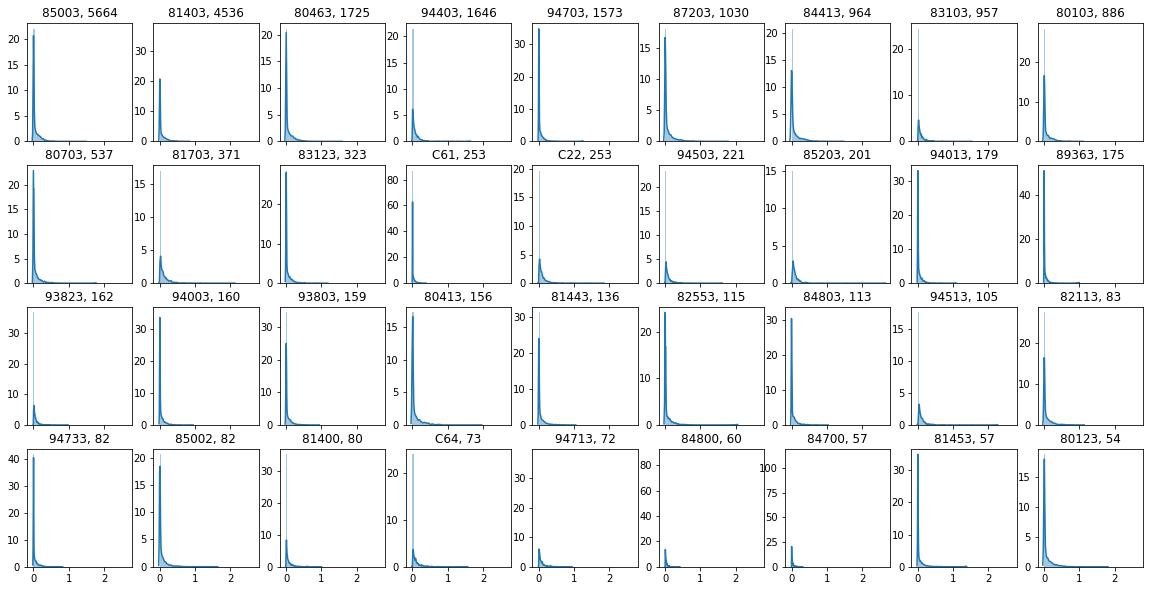

In [10]:
fig, axs = plt.subplots(4, 9, figsize=(20, 10), sharex=True, sharey=False)
r,c = 0, 0
for dname in disease_names:
    disease_data = postive_data[disease_labels == dname]
    sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]
    
    sns.distplot(sigsum, ax=axs[r, c])
    axs[r, c].set_title('{}, {}'.format(dname, int(df.loc[df.code == dname  , 'count'])))
    if c == 8:
        r += 1
        c = 0
    else:
        c += 1


### Using merged subtype names

Disease names from curation

In [11]:
disease_names = list(np.unique(subtypes['disease']))

disease_names.remove('NA')

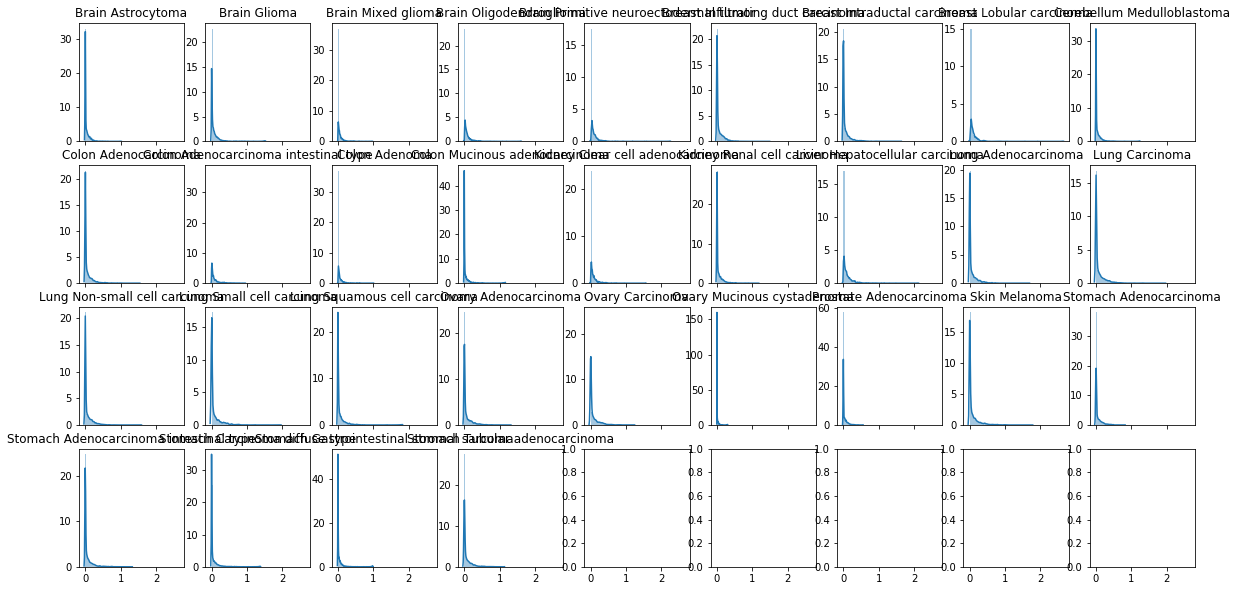

In [12]:
fig, axs = plt.subplots(4, 9, figsize=(20, 10), sharex=True, sharey=False)
r,c = 0, 0
for dname in disease_names:
    disease_data = postive_data[subtypes['disease'] == dname]
    sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]
    
    sns.distplot(sigsum, ax=axs[r, c])
    axs[r, c].set_title('{}'.format(dname))
    if c == 8:
        r += 1
        c = 0
    else:
        c += 1

## Use a classifier to evaluate the best threshold (1-fold)

In [13]:
disease_names = list(np.unique(subtypes['disease']))
disease_names.remove('NA')

In [14]:
all_results = []
all_high_filters = []

In [28]:
for sig_thresh in np.arange(0, 0.32, 0.02):

    
    # find high impact bands
    high_impact_genes = [False] * data.shape[1]

    for dname in disease_names:
        disease_data = postive_data[subtypes['disease'] == dname]
        sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]    
        high_impact_genes = np.add(high_impact_genes, sigsum>sig_thresh)

    # prepare feature matrix
    names = pd.DataFrame(np.unique(subtypes['disease'], return_counts=True)).transpose()
    names = names.rename(columns={0:'disease',1:'count'})
    names = names[names['disease'] != 'NA']
    names = names.reset_index(drop=True)
    names['target'] = names.index 
    names = names[['disease', 'target']]

    dlt = pd.merge(subtypes, names, how='left', on='disease')

    d = fm[subtypes['disease'] != 'NA'][:,high_impact_genes]
    l = subtypes.loc[subtypes['disease'] != 'NA', 'disease'].to_numpy()
    t = dlt.loc[subtypes['disease'] != 'NA', 'target'].to_numpy().astype(int)
    n = names['disease'].to_numpy()

    dd = {'data': d, 'label':l, 'target':t, 'name':n }
    
    # evaluate results
    td, tl = under_sample(dd, 'Breast Infiltrating duct carcinoma', 1700)
    result = cross_validation(td, tl,
                                spliter = StratifiedShuffleSplit(n_splits=1, test_size=0.3),
                                sampler = sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0, n_jobs=10)),
                                model = RandomForestClassifier(n_estimators=1000, n_jobs=10))
    
    all_results.append(result)
    all_high_filters.append(high_impact_genes)

2020-09-05 20:06:42,615:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 20:06:42,627:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-05 20:06:42,641:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:06:44,242:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-05 20:06:44,267:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:06:45,939:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-05 20:06:45,966:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:06:48,347:INFO:MulticlassOversampling: Sampling

2020-09-05 20:08:20,160:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:11:00,472:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 20:11:00,480:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-05 20:11:00,488:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:11:01,487:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-05 20:11:01,500:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:11:02,493:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-05 20:11:02,510:INFO:ProWSyn: Running sampling via ('

2020-09-05 20:12:00,376:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-05 20:12:00,464:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:13:59,788:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 20:13:59,795:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-05 20:13:59,803:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:14:00,767:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-05 20:14:00,779:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:14:01,764:INFO:MulticlassOversampling: Samplin

2020-09-05 20:14:49,018:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:14:54,982:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-05 20:14:55,051:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:16:43,872:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 20:16:43,879:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-05 20:16:43,886:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:16:44,842:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-05 20:16:44,851:INFO:ProWSyn: Running sampling via 

2020-09-05 20:17:39,084:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-05 20:17:39,150:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:17:40,310:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-05 20:17:40,379:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:19:23,603:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 20:19:23,609:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-05 20:19:23,616:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:19:24,573:INFO:MulticlassOversampling: Sampli

2020-09-05 20:20:15,380:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:20:17,181:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-05 20:20:17,243:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:20:19,518:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-05 20:20:19,583:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:21:59,646:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 20:21:59,654:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-05 20:21:59,661:INFO:ProWSyn: Runn

2020-09-05 20:22:42,491:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-05 20:22:42,546:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:22:43,626:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-05 20:22:43,686:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:22:45,429:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-05 20:22:45,488:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:24:25,406:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 20:24:25,412:INFO:MulticlassOve

2020-09-05 20:25:17,522:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:25:22,755:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-05 20:25:22,802:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:25:24,178:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-05 20:25:24,232:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:25:25,419:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-05 20:25:25,473:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'ra

2020-09-05 20:27:42,914:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-05 20:27:42,961:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:27:43,897:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-05 20:27:43,943:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:27:45,472:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-05 20:27:45,526:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:27:48,835:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-05 20:27:48,890:INFO:ProWSyn: Running sampling via ('ProWSyn', "{

2020-09-05 20:29:53,504:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:29:54,475:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-05 20:29:54,515:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:29:55,529:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-05 20:29:55,577:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:29:56,574:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-05 20:29:56,624:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'ra

2020-09-05 20:31:57,259:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-05 20:31:57,298:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:31:58,286:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-05 20:31:58,330:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:32:00,633:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-05 20:32:00,679:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:32:02,288:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-05 20:32:02,337:INFO:ProWSyn: Running sampling via ('ProWSyn', "{

2020-09-05 20:33:59,242:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:34:00,205:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-05 20:34:00,250:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:34:06,733:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-05 20:34:06,777:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:34:08,877:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-05 20:34:08,916:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'r

2020-09-05 20:36:00,401:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-05 20:36:00,437:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:36:01,096:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-05 20:36:01,134:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:36:02,267:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-05 20:36:02,305:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:36:03,103:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-05 20:36:03,143:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-05 20:37:49,889:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:37:51,627:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-05 20:37:51,663:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:37:52,777:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-05 20:37:52,812:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:37:53,667:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-05 20:37:53,704:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'rand

2020-09-05 20:39:41,415:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-05 20:39:41,442:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:39:42,051:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-05 20:39:42,082:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:39:43,677:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-05 20:39:43,712:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:39:44,960:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-05 20:39:44,995:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-05 20:41:28,343:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:41:29,756:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-05 20:41:29,781:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:41:34,723:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-05 20:41:34,757:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:41:35,570:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-05 20:41:35,600:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'ran

2020-09-05 20:43:19,348:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-05 20:43:19,373:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:43:20,028:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-05 20:43:20,059:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:43:20,660:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-05 20:43:20,686:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 20, 'random_state': None}")
2020-09-05 20:43:21,342:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-05 20:43:21,376:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

In [29]:
mtr = [[],[],[],[],[]]

for r,f in zip(all_results, all_high_filters):
    r = r[0]
    mtr[0].append(metrics.accuracy_score(r[0], r[1]))
    mtr[1].append(metrics.precision_score(r[0], r[1], average='macro'))
    mtr[2].append(metrics.recall_score(r[0], r[1], average='macro'))
    mtr[3].append(metrics.f1_score(r[0], r[1], average='macro'))
    mtr[4].append(sum(f))

pd.DataFrame({'thresh': np.arange(0, 0.32, 0.02),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})

,thresh,accuracy,precision,recall,f1,features
0,0.00,0.570436,0.437560,0.450577,0.436140,2905
1,0.02,0.543366,0.409165,0.435614,0.414639,1598
2,0.04,0.559038,0.426085,0.445598,0.427194,1360
3,0.06,0.547996,0.398222,0.427369,0.404853,1224
4,0.08,0.547462,0.433184,0.456915,0.435676,1127
5,0.10,0.558860,0.429321,0.436660,0.424049,1037
6,0.12,0.541763,0.405855,0.415063,0.404777,962
7,0.14,0.541229,0.404518,0.418004,0.403223,892
8,0.16,0.542654,0.407454,0.419255,0.404964,835
9,0.18,0.530365,0.388507,0.419594,0.395524,786


In [30]:
for r, t in zip(all_results, np.arange(0, 0.32, 0.02)):
    
    r = r[0]
    if t == 0:
        classes = evaluate_classes(r, names=dd['name'], sort='Label', ascending=True)
        classes = classes[['Label','F1-score']]
        classes = classes.rename(columns = {'F1-score':str(t)})
    else:
        c = evaluate_classes(r, names=dd['name'], sort='Label', ascending=True)
        c = c[['Label','F1-score']]
        c = c.rename(columns = {'F1-score':str(t)})

        classes = pd.merge(classes, c, how='left', on='Label')

classes


,Label,0.0,0.02,0.04,0.06,0.08,0.1,0.12,0.14,0.16,0.18,0.2,0.22,0.24,0.26,0.28,0.3
0,Brain Astrocytoma,0.243094,0.236559,0.326087,0.240838,0.256158,0.208589,0.282723,0.250000,0.262295,0.238342,0.281250,0.256410,0.301676,0.258824,0.275510,0.262136
1,Brain Glioma,0.704797,0.701181,0.696364,0.690181,0.666667,0.679417,0.686703,0.673267,0.704692,0.693727,0.703499,0.676364,0.680734,0.658737,0.680036,0.670290
2,Brain Mixed glioma,0.170732,0.133333,0.229167,0.164706,0.195122,0.192308,0.252874,0.141176,0.157303,0.219512,0.160000,0.144578,0.229885,0.211538,0.190476,0.161616
3,Brain Oligodendroglioma,0.387097,0.308824,0.310078,0.380282,0.402985,0.411765,0.359375,0.362319,0.464789,0.356589,0.384106,0.429630,0.444444,0.405594,0.428571,0.420290
4,Brain Primitive neuroectodermal tumor,0.372881,0.181818,0.290909,0.202899,0.357143,0.083333,0.230769,0.181818,0.241379,0.185185,0.280702,0.280702,0.222222,0.230769,0.333333,0.400000
5,Breast Infiltrating duct carcinoma,0.531513,0.474429,0.508901,0.465016,0.511135,0.528497,0.481521,0.521081,0.499498,0.461707,0.523549,0.497286,0.490323,0.478166,0.463799,0.534759
6,Breast Intraductal carcinoma,0.734694,0.745098,0.760000,0.577778,0.723404,0.784314,0.693878,0.681818,0.590909,0.625000,0.714286,0.716981,0.576923,0.680000,0.666667,0.666667
7,Breast Lobular carcinoma,0.601399,0.546584,0.613333,0.589744,0.526316,0.601399,0.454545,0.565517,0.454545,0.503145,0.523810,0.509091,0.484848,0.530120,0.481481,0.487805
8,Cerebellum Medulloblastoma,0.703544,0.688869,0.707162,0.685965,0.669611,0.696785,0.683142,0.690817,0.697264,0.687831,0.704645,0.680592,0.684303,0.701322,0.677996,0.653946
9,Colon Adenocarcinoma,0.706458,0.646035,0.690453,0.689060,0.689792,0.708249,0.688363,0.683897,0.681407,0.661323,0.709486,0.719212,0.689585,0.659406,0.643496,0.706237


## prepare labels

In [77]:
names = pd.DataFrame(np.unique(subtypes['disease'], return_counts=True)).transpose()
names = names.rename(columns={0:'disease',1:'count'})
names = names[names['disease'] != 'NA']
names = names.reset_index(drop=True)
names['target'] = names.index 
names = names[['disease', 'target']]

dlt = pd.merge(subtypes, names, how='left', on='disease')

l = subtypes.loc[subtypes['disease'] != 'NA', 'disease'].to_numpy()
t = dlt.loc[subtypes['disease'] != 'NA', 'target'].to_numpy().astype(int)
n = names['disease'].to_numpy()

## Fine grid search for the best cut-off

In [32]:
np.arange(0, 0.12, 0.005).shape

(24,)

In [36]:
all_results_best = []
all_high_filters_best = []

for sig_thresh in np.arange(0, 0.12, 0.005):

    
    # find high impact bands
    high_impact_genes = [False] * data.shape[1]

    for dname in disease_names:
        disease_data = postive_data[subtypes['disease'] == dname]
        sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]    
        high_impact_genes = np.add(high_impact_genes, sigsum>sig_thresh)

    # prepare feature matrix
    d = fm[subtypes['disease'] != 'NA'][:,high_impact_genes]
    dd = {'data': d, 'label':l, 'target':t, 'name':n }
    
    # evaluate results
    td, tl = under_sample(dd, 'Breast Infiltrating duct carcinoma', 1700)
    result = cross_validation(td, tl,
                                spliter = StratifiedShuffleSplit(n_splits=5, test_size=0.3),
                                sampler = sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0, n_jobs=18)),
                                model = RandomForestClassifier(n_estimators=1000, n_jobs=18))

    all_results_best.append(result)
    all_high_filters_best.append(high_impact_genes)

2020-09-05 20:53:20,327:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 20:53:20,344:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-05 20:53:20,359:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 20:53:22,004:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-05 20:53:22,028:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 20:53:23,714:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-05 20:53:23,745:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 20:53:26,538:INFO:MulticlassOversampling: Sampling

2020-09-05 20:54:40,659:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 20:57:38,850:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 20:57:38,863:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-05 20:57:38,879:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 20:57:40,510:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-05 20:57:40,534:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 20:57:42,214:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-05 20:57:42,244:INFO:ProWSyn: Running sampling via ('

2020-09-05 20:58:59,171:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-05 20:58:59,308:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:01:57,016:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 21:01:57,028:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-05 21:01:57,044:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:01:58,695:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-05 21:01:58,719:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:02:00,439:INFO:MulticlassOversampling: Samplin

2020-09-05 21:03:15,387:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:03:17,313:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-05 21:03:17,452:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:06:11,738:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 21:06:11,751:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-05 21:06:11,766:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:06:13,422:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-05 21:06:13,449:INFO:ProWSyn: Running sampling via 

2020-09-05 21:07:30,042:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-05 21:07:30,179:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:07:33,469:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-05 21:07:33,610:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:10:31,146:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 21:10:31,158:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-05 21:10:31,174:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:10:32,826:INFO:MulticlassOversampling: Sampli

2020-09-05 21:11:41,831:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:11:44,506:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-05 21:11:44,643:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:11:47,616:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-05 21:11:47,757:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:14:44,685:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 21:14:44,695:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-05 21:14:44,707:INFO:ProWSyn: Runn

2020-09-05 21:15:46,750:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-05 21:15:46,862:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:15:49,892:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-05 21:15:50,005:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:15:51,727:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-05 21:15:51,843:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:18:26,205:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 21:18:26,215:INFO:MulticlassOve

2020-09-05 21:19:22,290:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:19:24,222:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-05 21:19:24,332:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:19:26,874:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-05 21:19:26,989:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:19:30,351:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-05 21:19:30,466:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ra

2020-09-05 21:23:11,449:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-05 21:23:11,555:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:23:14,283:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-05 21:23:14,393:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:23:16,302:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-05 21:23:16,417:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:23:18,314:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-05 21:23:18,428:INFO:ProWSyn: Running sampling via ('ProWSyn', "{

2020-09-05 21:26:44,503:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:26:46,082:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-05 21:26:46,193:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:26:48,690:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-05 21:26:48,801:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:26:51,458:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-05 21:26:51,571:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ra

2020-09-05 21:30:16,747:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-05 21:30:16,849:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:30:18,537:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-05 21:30:18,644:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:30:20,418:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-05 21:30:20,527:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:30:23,371:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-05 21:30:23,485:INFO:ProWSyn: Running sampling via ('ProWSyn', "{

2020-09-05 21:33:46,552:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:33:47,633:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-05 21:33:47,715:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:33:50,015:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-05 21:33:50,122:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:33:52,707:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-05 21:33:52,818:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'r

2020-09-05 21:37:04,574:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-05 21:37:04,667:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:37:06,621:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-05 21:37:06,705:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:37:08,642:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-05 21:37:08,735:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:37:10,288:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-05 21:37:10,394:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-05 21:40:19,978:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:40:21,897:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-05 21:40:22,008:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:40:23,605:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-05 21:40:23,690:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:40:30,069:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-05 21:40:30,174:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-05 21:43:38,453:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-05 21:43:38,540:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:43:40,184:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-05 21:43:40,276:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:43:41,696:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-05 21:43:41,778:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:43:44,159:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-05 21:43:44,257:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-05 21:46:55,205:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:46:57,150:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-05 21:46:57,235:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:46:59,184:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-05 21:46:59,276:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:47:01,236:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-05 21:47:01,318:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ran

2020-09-05 21:50:11,317:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-05 21:50:11,391:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:50:12,519:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-05 21:50:12,592:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:50:14,373:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-05 21:50:14,452:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:50:16,400:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-05 21:50:16,485:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-05 21:53:18,505:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:53:19,604:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-05 21:53:19,667:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:53:21,000:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-05 21:53:21,075:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:53:23,528:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-05 21:53:23,610:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-05 21:56:27,791:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-05 21:56:27,857:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:56:29,496:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-05 21:56:29,570:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:56:31,343:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-05 21:56:31,416:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:56:32,602:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-05 21:56:32,681:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-05 21:59:30,538:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:59:32,399:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-05 21:59:32,479:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:59:33,524:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-05 21:59:33,591:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 21:59:36,580:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-05 21:59:36,666:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-05 22:02:41,521:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-05 22:02:41,590:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:02:42,690:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-05 22:02:42,756:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:02:43,823:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-05 22:02:43,899:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:02:46,607:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-05 22:02:46,683:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-05 22:05:46,387:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:05:47,851:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-05 22:05:47,915:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:05:49,221:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-05 22:05:49,288:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:05:50,338:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-05 22:05:50,418:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ra

2020-09-05 22:08:44,799:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-05 22:08:44,860:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:08:45,826:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-05 22:08:45,890:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:08:47,108:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-05 22:08:47,178:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:08:48,853:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-05 22:08:48,928:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-05 22:11:37,836:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:11:39,269:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-05 22:11:39,331:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:11:40,803:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-05 22:11:40,867:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:11:42,590:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-05 22:11:42,657:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'r

2020-09-05 22:14:35,718:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-05 22:14:35,779:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:14:37,972:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-05 22:14:38,034:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:14:39,773:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-05 22:14:39,838:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:14:42,833:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-05 22:14:42,901:INFO:ProWSyn: Running sampling via ('ProWSyn', "

2020-09-05 22:17:36,816:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:17:37,888:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-05 22:17:37,948:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:17:38,995:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-05 22:17:39,058:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:17:40,820:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-05 22:17:40,885:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ran

2020-09-05 22:20:31,781:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-05 22:20:31,836:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:20:32,847:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-05 22:20:32,906:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:20:33,866:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-05 22:20:33,923:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:20:34,889:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-05 22:20:34,950:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-05 22:23:24,965:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:23:26,922:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-05 22:23:26,976:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:23:27,906:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-05 22:23:27,967:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:23:28,935:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-05 22:23:28,995:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-05 22:26:11,900:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-05 22:26:11,950:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:26:13,127:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-05 22:26:13,182:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:26:14,165:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-05 22:26:14,224:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:26:15,164:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-05 22:26:15,221:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-05 22:29:09,925:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:29:11,353:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-05 22:29:11,406:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:29:13,929:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-05 22:29:13,988:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:29:15,118:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-05 22:29:15,174:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random

2020-09-05 22:32:04,916:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-05 22:32:04,965:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:32:06,948:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-05 22:32:07,001:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:32:08,387:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-05 22:32:08,441:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:32:09,395:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-05 22:32:09,452:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-09-05 22:34:54,139:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:34:56,131:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-05 22:34:56,182:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:34:58,169:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-05 22:34:58,220:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:35:00,219:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-05 22:35:00,272:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_s

2020-09-05 22:37:43,019:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-05 22:37:43,064:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:37:44,054:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-05 22:37:44,105:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:37:45,321:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-05 22:37:45,372:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:37:46,675:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-05 22:37:46,727:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-05 22:40:25,797:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:40:27,596:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-05 22:40:27,644:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:40:28,855:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-05 22:40:28,904:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:40:30,877:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-05 22:40:30,930:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_

2020-09-05 22:43:17,547:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-05 22:43:17,590:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:43:18,667:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-05 22:43:18,712:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:43:19,703:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-05 22:43:19,753:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:43:20,808:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-05 22:43:20,869:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-05 22:46:00,984:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:46:02,785:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-05 22:46:02,829:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:46:04,097:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-05 22:46:04,143:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:46:05,817:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-05 22:46:05,866:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_

2020-09-05 22:48:49,423:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-05 22:48:49,462:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:48:50,617:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-05 22:48:50,657:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:48:51,793:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-05 22:48:51,845:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:48:52,829:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-05 22:48:52,886:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-05 22:51:33,323:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:51:34,628:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-05 22:51:34,667:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:51:35,771:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-05 22:51:35,808:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:51:38,634:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-05 22:51:38,679:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random

2020-09-05 22:54:21,889:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-05 22:54:21,930:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:54:23,251:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-05 22:54:23,289:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:54:24,329:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-05 22:54:24,368:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:54:25,583:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-05 22:54:25,627:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-05 22:57:10,288:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:57:11,784:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-05 22:57:11,820:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:57:13,239:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-05 22:57:13,278:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:57:14,665:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-05 22:57:14,704:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random

2020-09-05 22:59:56,009:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-05 22:59:56,048:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:59:57,441:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-05 22:59:57,477:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 22:59:58,911:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-05 22:59:58,951:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:00:00,046:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-05 23:00:00,085:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-05 23:02:43,641:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:02:45,506:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-05 23:02:45,540:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:02:46,866:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-05 23:02:46,905:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:02:48,209:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-05 23:02:48,253:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

2020-09-05 23:05:25,056:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-05 23:05:25,087:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:05:26,950:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-05 23:05:26,982:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:05:28,902:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-05 23:05:28,941:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:05:30,271:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-05 23:05:30,315:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-05 23:08:00,598:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:08:02,435:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-05 23:08:02,471:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:08:04,320:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-05 23:08:04,355:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:08:05,678:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-05 23:08:05,726:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ran

2020-09-05 23:10:43,167:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-05 23:10:43,196:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:10:45,039:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-05 23:10:45,072:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:10:46,947:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-05 23:10:46,977:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:10:48,464:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-05 23:10:48,501:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-05 23:13:27,554:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:13:29,087:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-05 23:13:29,116:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:13:30,982:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-05 23:13:31,013:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:13:32,872:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-05 23:13:32,905:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

2020-09-05 23:16:10,340:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-05 23:16:10,371:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:16:11,935:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-05 23:16:11,961:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:16:13,828:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-05 23:16:13,864:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:16:15,738:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-05 23:16:15,772:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-05 23:18:47,537:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:18:49,116:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-05 23:18:49,151:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:18:50,712:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-05 23:18:50,738:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:18:52,574:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-05 23:18:52,603:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-05 23:21:22,702:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-05 23:21:22,727:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:21:24,294:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-05 23:21:24,326:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:21:25,881:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-05 23:21:25,910:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:21:27,772:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-05 23:21:27,810:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-05 23:24:05,997:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:24:07,286:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-05 23:24:07,312:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:24:08,921:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-05 23:24:08,952:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:24:10,503:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-05 23:24:10,527:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-05 23:26:49,234:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-05 23:26:49,260:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:26:50,535:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-05 23:26:50,563:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:26:52,146:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-05 23:26:52,175:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:26:53,736:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-05 23:26:53,761:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-05 23:29:33,143:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:29:34,935:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-05 23:29:34,957:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:29:36,367:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-05 23:29:36,391:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:29:37,697:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-05 23:29:37,724:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

2020-09-05 23:32:13,105:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-05 23:32:13,127:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:32:14,833:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-05 23:32:14,855:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:32:16,122:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-05 23:32:16,147:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:32:17,773:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-05 23:32:17,804:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-05 23:34:52,560:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:34:54,104:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-05 23:34:54,126:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:34:55,819:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-05 23:34:55,844:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:34:57,119:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-05 23:34:57,147:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-05 23:37:30,006:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-05 23:37:30,024:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:37:31,563:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-05 23:37:31,585:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:37:33,171:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-05 23:37:33,192:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:37:34,476:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-05 23:37:34,501:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-05 23:40:06,708:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:40:08,134:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-05 23:40:08,154:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:40:09,596:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-05 23:40:09,618:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:40:11,214:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-05 23:40:11,236:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

2020-09-05 23:42:44,797:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-05 23:42:44,812:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:42:46,142:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-05 23:42:46,159:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:42:47,717:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-05 23:42:47,740:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:42:49,523:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-05 23:42:49,545:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-05 23:45:19,035:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:45:19,909:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-05 23:45:19,924:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:45:21,254:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-05 23:45:21,273:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:45:22,823:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-05 23:45:22,845:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_

2020-09-05 23:47:51,235:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-05 23:47:51,246:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:47:52,114:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-05 23:47:52,128:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:47:53,461:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-05 23:47:53,479:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:47:54,945:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-05 23:47:54,970:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-05 23:50:25,632:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:50:26,628:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-05 23:50:26,640:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:50:27,506:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-05 23:50:27,520:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:50:28,861:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-05 23:50:28,879:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")

2020-09-05 23:52:58,685:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 23:52:58,691:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-05 23:52:58,699:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:52:59,669:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-05 23:52:59,680:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:53:00,549:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-05 23:53:00,563:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:53:01,769:INFO:MulticlassOversampling: Sampling

2020-09-05 23:53:41,112:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:55:37,222:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 23:55:37,228:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-05 23:55:37,235:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:55:38,198:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-05 23:55:38,210:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:55:39,059:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-05 23:55:39,072:INFO:ProWSyn: Running sampling via ('

2020-09-05 23:56:18,390:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-05 23:56:18,459:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:58:08,529:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-05 23:58:08,536:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-05 23:58:08,544:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:58:09,514:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-05 23:58:09,526:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:58:10,382:INFO:MulticlassOversampling: Samplin

2020-09-05 23:58:48,029:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-05 23:58:49,616:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-05 23:58:49,687:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:00:40,112:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 00:00:40,119:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 00:00:40,126:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:00:41,106:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 00:00:41,117:INFO:ProWSyn: Running sampling via 

2020-09-06 00:01:16,789:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 00:01:16,857:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:01:18,219:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 00:01:18,305:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:03:08,274:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 00:03:08,281:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 00:03:08,289:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:03:09,272:INFO:MulticlassOversampling: Sampli

2020-09-06 00:03:44,809:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:03:46,778:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 00:03:46,847:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:03:47,759:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 00:03:47,834:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:05:37,831:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 00:05:37,838:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 00:05:37,845:INFO:ProWSyn: Runn

2020-09-06 00:06:14,014:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 00:06:14,074:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:06:14,901:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 00:06:14,969:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:06:15,866:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 00:06:15,941:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:08:08,484:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 00:08:08,490:INFO:MulticlassOve

2020-09-06 00:08:44,202:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:08:45,952:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 00:08:46,032:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:08:46,835:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 00:08:46,903:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:08:47,839:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 00:08:47,907:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ra

2020-09-06 00:11:17,080:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 00:11:17,143:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:11:19,286:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 00:11:19,349:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:11:20,647:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 00:11:20,712:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:11:21,650:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 00:11:21,719:INFO:ProWSyn: Running sampling via ('ProWSyn', "{

2020-09-06 00:13:43,418:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:13:44,427:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 00:13:44,492:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:13:46,876:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 00:13:46,942:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:13:48,649:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 00:13:48,716:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ra

2020-09-06 00:16:15,300:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 00:16:15,361:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:16:16,345:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 00:16:16,409:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:16:18,753:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 00:16:18,818:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:16:20,391:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 00:16:20,458:INFO:ProWSyn: Running sampling via ('ProWSyn', "{

2020-09-06 00:18:41,899:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:18:43,124:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 00:18:43,196:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:18:44,139:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 00:18:44,201:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:18:45,148:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 00:18:45,214:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'r

2020-09-06 00:21:14,195:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 00:21:14,251:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:21:15,418:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 00:21:15,487:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:21:17,061:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 00:21:17,122:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:21:18,861:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 00:21:18,925:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-06 00:23:45,012:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:23:46,141:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 00:23:46,199:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:23:47,178:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 00:23:47,241:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:23:49,171:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 00:23:49,234:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 00:26:15,984:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 00:26:16,040:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:26:16,926:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 00:26:16,982:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:26:18,015:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 00:26:18,086:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:26:19,173:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 00:26:19,235:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 00:28:39,165:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:28:42,344:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 00:28:42,401:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:28:44,310:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 00:28:44,365:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:28:45,970:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 00:28:46,029:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ran

2020-09-06 00:31:10,908:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 00:31:10,968:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:31:13,974:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 00:31:14,032:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:31:15,013:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 00:31:15,068:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:31:16,177:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 00:31:16,238:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 00:33:47,861:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:33:49,101:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 00:33:49,153:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:33:51,128:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 00:33:51,185:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:33:51,926:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 00:33:51,983:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 00:36:14,956:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 00:36:15,007:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:36:15,973:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 00:36:16,032:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:36:18,014:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 00:36:18,070:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:36:19,193:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 00:36:19,250:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 00:38:41,722:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:38:42,863:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 00:38:42,915:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:38:43,719:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 00:38:43,770:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:38:44,990:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 00:38:45,047:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 00:41:04,480:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 00:41:04,528:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:41:05,632:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 00:41:05,683:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:41:06,675:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 00:41:06,728:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:41:08,712:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 00:41:08,769:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-06 00:43:28,497:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:43:29,477:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 00:43:29,523:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:43:30,361:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 00:43:30,423:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:43:31,247:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 00:43:31,308:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ra

2020-09-06 00:45:57,588:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 00:45:57,634:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:45:59,012:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 00:45:59,061:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:45:59,971:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 00:46:00,022:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:46:02,391:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 00:46:02,441:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-06 00:48:22,459:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:48:23,440:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 00:48:23,486:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:48:24,280:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 00:48:24,327:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:48:25,648:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 00:48:25,698:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'r

2020-09-06 00:50:46,038:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 00:50:46,082:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:50:46,851:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 00:50:46,896:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:50:47,768:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 00:50:47,814:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:50:48,719:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 00:50:48,768:INFO:ProWSyn: Running sampling via ('ProWSyn', "

2020-09-06 00:53:15,174:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:53:16,057:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 00:53:16,102:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:53:17,178:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 00:53:17,224:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:53:18,086:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 00:53:18,134:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ran

2020-09-06 00:55:41,425:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 00:55:41,472:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:55:42,547:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 00:55:42,593:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:55:45,280:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 00:55:45,326:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:55:46,119:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 00:55:46,174:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 00:58:13,904:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:58:15,194:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 00:58:15,234:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:58:15,986:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 00:58:16,024:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 00:58:18,442:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 00:58:18,487:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 01:00:46,996:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 01:00:47,035:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:00:49,163:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 01:00:49,203:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:00:50,043:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 01:00:50,082:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:00:55,546:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 01:00:55,590:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 01:03:18,231:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:03:20,647:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 01:03:20,686:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:03:22,506:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 01:03:22,547:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:03:23,631:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 01:03:23,670:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random

2020-09-06 01:05:44,441:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 01:05:44,474:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:05:46,275:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 01:05:46,317:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:05:48,342:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 01:05:48,381:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:05:49,242:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 01:05:49,282:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-09-06 01:08:11,146:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:08:12,118:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 01:08:12,152:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:08:13,302:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 01:08:13,340:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:08:14,663:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 01:08:14,703:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_s

2020-09-06 01:10:41,972:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 01:10:42,004:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:10:43,012:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 01:10:43,056:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:10:44,032:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 01:10:44,072:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:10:45,829:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 01:10:45,866:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-06 01:13:04,845:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:13:06,009:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 01:13:06,043:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:13:06,864:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 01:13:06,898:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:13:07,749:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 01:13:07,788:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_

2020-09-06 01:15:26,750:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 01:15:26,784:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:15:27,718:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 01:15:27,751:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:15:28,739:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 01:15:28,774:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:15:29,993:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 01:15:30,032:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-06 01:17:45,626:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:17:46,516:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 01:17:46,549:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:17:47,473:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 01:17:47,510:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:17:48,704:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 01:17:48,742:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_

2020-09-06 01:20:05,688:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 01:20:05,716:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:20:07,391:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 01:20:07,425:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:20:08,415:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 01:20:08,447:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:20:09,464:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 01:20:09,499:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-06 01:22:30,562:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:22:32,194:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 01:22:32,220:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:22:33,160:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 01:22:33,193:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:22:34,090:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 01:22:34,125:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random

2020-09-06 01:24:51,871:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 01:24:51,904:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:24:53,064:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 01:24:53,095:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:24:54,011:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 01:24:54,048:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:24:55,274:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 01:24:55,309:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-06 01:27:14,627:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:27:16,016:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 01:27:16,040:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:27:17,190:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 01:27:17,217:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:27:18,168:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 01:27:18,204:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random

2020-09-06 01:29:33,876:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 01:29:33,905:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:29:35,310:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 01:29:35,343:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:29:36,883:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 01:29:36,910:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:29:38,095:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 01:29:38,126:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 01:31:53,016:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:31:54,870:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 01:31:54,899:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:31:56,380:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 01:31:56,408:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:31:57,633:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 01:31:57,660:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

2020-09-06 01:34:18,678:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 01:34:18,703:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:34:20,331:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 01:34:20,360:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:34:21,606:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 01:34:21,630:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:34:22,786:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 01:34:22,812:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 01:36:38,530:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:36:40,028:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 01:36:40,055:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:36:41,583:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 01:36:41,612:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:36:42,753:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 01:36:42,784:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ran

2020-09-06 01:39:03,561:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 01:39:03,586:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:39:05,186:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 01:39:05,212:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:39:06,804:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 01:39:06,835:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:39:08,189:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 01:39:08,216:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-06 01:41:25,805:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:41:27,104:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 01:41:27,126:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:41:28,715:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 01:41:28,740:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:41:30,086:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 01:41:30,112:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

2020-09-06 01:43:53,806:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 01:43:53,827:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:43:55,157:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 01:43:55,179:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:43:56,787:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 01:43:56,810:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:43:58,169:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 01:43:58,200:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 01:46:16,165:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:46:17,497:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 01:46:17,517:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:46:18,843:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 01:46:18,865:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:46:20,443:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 01:46:20,466:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 01:48:35,594:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 01:48:35,614:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:48:36,960:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 01:48:36,984:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:48:38,307:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 01:48:38,329:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:48:40,042:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 01:48:40,069:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 01:50:55,422:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:50:56,594:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 01:50:56,616:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:50:57,976:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 01:50:58,003:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:50:59,319:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 01:50:59,343:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 01:53:16,884:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 01:53:16,902:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:53:18,090:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 01:53:18,111:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:53:19,443:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 01:53:19,463:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:53:20,777:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 01:53:20,800:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 01:55:36,576:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:55:38,024:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 01:55:38,053:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:55:39,199:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 01:55:39,219:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:55:40,543:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 01:55:40,563:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

2020-09-06 01:58:01,030:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 01:58:01,045:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:58:02,502:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 01:58:02,520:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:58:03,707:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 01:58:03,729:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 01:58:05,078:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 01:58:05,101:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 02:00:21,188:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:00:22,386:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 02:00:22,403:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:00:23,732:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 02:00:23,751:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:00:24,918:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 02:00:24,936:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 02:02:39,950:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 02:02:39,964:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:02:41,045:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 02:02:41,060:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:02:42,500:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 02:02:42,521:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:02:43,553:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 02:02:43,572:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 02:05:02,530:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:05:03,713:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 02:05:03,726:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:05:04,945:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 02:05:04,959:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:05:06,284:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 02:05:06,305:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

2020-09-06 02:07:24,592:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 02:07:24,603:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:07:25,685:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 02:07:25,698:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:07:26,922:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 02:07:26,937:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:07:28,261:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 02:07:28,279:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-06 02:09:45,427:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:09:46,177:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 02:09:46,187:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:09:47,286:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 02:09:47,299:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:09:48,499:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 02:09:48,513:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_

2020-09-06 02:12:06,104:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 02:12:06,114:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:12:06,840:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 02:12:06,851:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:12:08,053:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 02:12:08,069:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:12:09,277:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 02:12:09,293:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-06 02:14:25,892:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:14:26,637:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 02:14:26,646:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:14:27,377:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 02:14:27,388:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:14:28,597:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 02:14:28,613:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")

2020-09-06 02:16:46,716:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 02:16:46,722:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 02:16:46,729:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:16:47,485:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 02:16:47,495:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:16:48,224:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 02:16:48,235:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:16:49,337:INFO:MulticlassOversampling: Sampling

2020-09-06 02:17:27,940:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:19:08,723:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 02:19:08,730:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 02:19:08,737:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:19:09,496:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 02:19:09,505:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 02:19:10,236:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 02:19:10,248:INFO:ProWSyn: Running sampling via ('

2020-09-06 02:19:45,110:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 02:19:45,168:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")


In [37]:
mtr = [[],[],[],[],[]]
n = 5
for res,f in zip(all_results_best, all_high_filters_best):
    acc, pre, rec, f1 = 0, 0, 0, 0
    for r in res:
        acc += metrics.accuracy_score(r[0], r[1])
        pre += metrics.precision_score(r[0], r[1], average='macro')
        rec += metrics.recall_score(r[0], r[1], average='macro')
        f1 += metrics.f1_score(r[0], r[1], average='macro')
    
    mtr[0].append(acc/n)
    mtr[1].append(pre/n)
    mtr[2].append(rec/n)
    mtr[3].append(f1/n)
    mtr[4].append(sum(f))
    
    
pd.DataFrame({'thresh': np.arange(0, 0.12, 0.005),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})

,thresh,accuracy,precision,recall,f1,features
0,0.000,0.557150,0.414563,0.437958,0.418815,2905
1,0.005,0.549849,0.412548,0.436425,0.416599,2159
2,0.010,0.548887,0.409729,0.429571,0.412096,1855
3,0.015,0.552983,0.413863,0.433448,0.416069,1705
4,0.020,0.550419,0.414427,0.442464,0.420435,1598
5,0.025,0.550917,0.413256,0.433663,0.415992,1511
6,0.030,0.544898,0.409166,0.426378,0.410167,1442
7,0.035,0.551095,0.417983,0.435126,0.419003,1390
8,0.040,0.547569,0.412869,0.431834,0.414594,1360
9,0.045,0.547605,0.417564,0.433602,0.417247,1317


In [39]:
mtr = [[],[],[],[],[]]

f = all_high_filters_best[23]
for r in all_results_best[23]:
#     r = r[0]
    mtr[0].append(metrics.accuracy_score(r[0], r[1]))
    mtr[1].append(metrics.precision_score(r[0], r[1], average='macro'))
    mtr[2].append(metrics.recall_score(r[0], r[1], average='macro'))
    mtr[3].append(metrics.f1_score(r[0], r[1], average='macro'))
    mtr[4].append(sum(f))

pd.DataFrame({'thresh': np.arange(0, 5, 1),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})

,thresh,accuracy,precision,recall,f1,features
0,0,0.549955,0.422282,0.438662,0.422570,977
1,1,0.545503,0.423311,0.437994,0.424084,977
2,2,0.547462,0.412917,0.435706,0.415236,977
3,3,0.559038,0.414283,0.433696,0.416001,977
4,4,0.559394,0.421106,0.444644,0.423993,977


It seems performance does not drop with increasing thresh, use wider steps to search for higher cut off

## Wider search (5-folds)

In [41]:
len(np.arange(0.12, 0.52, 0.02))

20

In [42]:
all_results_n = []
all_high_filters_n = []

for sig_thresh in np.arange(0.12, 0.52, 0.02):

    
    # find high impact bands
    high_impact_bands = [False] * data.shape[1]

    for dname in disease_names:
        disease_data = postive_data[subtypes['disease'] == dname]
        sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]    
        high_impact_bands = np.add(high_impact_bands, sigsum>sig_thresh)

    # prepare feature matrix
    d = fm[subtypes['disease'] != 'NA'][:,high_impact_bands]
    dd = {'data': d, 'label':l, 'target':t, 'name':n }
    
    # evaluate results
    td, tl = under_sample(dd, 'Breast Infiltrating duct carcinoma', 1700)
    result = cross_validation(td, tl,
                                spliter = StratifiedShuffleSplit(n_splits=5, test_size=0.3),
                                sampler = sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0, n_jobs=18)),
                                model = RandomForestClassifier(n_estimators=1000, n_jobs=18))

    all_results_n.append(result)
    all_high_filters_n.append(high_impact_bands)

2020-09-06 09:19:05,848:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 09:19:05,853:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 09:19:05,859:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:19:06,690:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 09:19:06,700:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:19:07,426:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 09:19:07,437:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:19:08,526:INFO:MulticlassOversampling: Sampling

2020-09-06 09:19:44,526:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:21:28,918:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 09:21:28,924:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 09:21:28,930:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:21:29,766:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 09:21:29,776:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:21:30,498:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 09:21:30,509:INFO:ProWSyn: Running sampling via ('

2020-09-06 09:22:04,982:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 09:22:05,044:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:23:47,119:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 09:23:47,125:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 09:23:47,132:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:23:47,970:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 09:23:47,980:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:23:48,708:INFO:MulticlassOversampling: Samplin

2020-09-06 09:24:27,878:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:24:28,947:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 09:24:29,006:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:26:10,066:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 09:26:10,072:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 09:26:10,079:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:26:10,916:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 09:26:10,925:INFO:ProWSyn: Running sampling via 

2020-09-06 09:26:47,373:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 09:26:47,426:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:26:48,409:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 09:26:48,466:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:28:29,054:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 09:28:29,059:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 09:28:29,066:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:28:29,812:INFO:MulticlassOversampling: Sampli

2020-09-06 09:29:02,121:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:29:03,094:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 09:29:03,157:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:29:04,191:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 09:29:04,249:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:30:46,521:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 09:30:46,527:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 09:30:46,532:INFO:ProWSyn: Runn

2020-09-06 09:31:24,946:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 09:31:24,997:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:31:26,209:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 09:31:26,263:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:31:28,979:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 09:31:29,040:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:33:03,816:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 09:33:03,822:INFO:MulticlassOve

2020-09-06 09:33:38,577:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:33:40,729:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 09:33:40,779:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:33:43,361:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 09:33:43,415:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:33:45,505:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 09:33:45,567:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ra

2020-09-06 09:35:55,666:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 09:35:55,714:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:35:59,026:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 09:35:59,076:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:36:00,725:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 09:36:00,778:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:36:02,766:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 09:36:02,817:INFO:ProWSyn: Running sampling via ('ProWSyn', "{

2020-09-06 09:38:07,448:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:38:09,006:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 09:38:09,054:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:38:10,846:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 09:38:10,897:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:38:13,463:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 09:38:13,526:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ra

2020-09-06 09:40:22,397:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 09:40:22,442:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:40:25,423:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 09:40:25,471:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:40:26,584:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 09:40:26,634:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:40:27,467:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 09:40:27,520:INFO:ProWSyn: Running sampling via ('ProWSyn', "{

2020-09-06 09:42:32,511:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:42:33,516:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 09:42:33,567:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:42:35,637:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 09:42:35,682:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:42:36,637:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 09:42:36,687:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'r

2020-09-06 09:44:41,015:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 09:44:41,054:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:44:42,129:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 09:44:42,175:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:44:44,695:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 09:44:44,744:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:44:46,222:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 09:44:46,269:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-06 09:46:54,255:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:46:54,986:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 09:46:55,030:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:46:55,819:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 09:46:55,863:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:46:57,979:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 09:46:58,025:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 09:49:15,256:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 09:49:15,296:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:49:16,005:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 09:49:16,045:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:49:16,925:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 09:49:16,970:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:49:18,405:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 09:49:18,450:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 09:51:17,432:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:51:18,301:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 09:51:18,342:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:51:19,510:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 09:51:19,549:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:51:20,261:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 09:51:20,304:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ran

2020-09-06 09:53:25,218:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 09:53:25,255:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:53:26,690:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 09:53:26,730:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:53:28,671:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 09:53:28,708:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:53:29,950:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 09:53:29,990:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 09:55:31,990:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:55:32,673:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 09:55:32,710:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:55:34,170:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 09:55:34,209:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:55:34,914:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 09:55:34,958:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 09:57:39,311:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 09:57:39,345:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:57:39,991:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 09:57:40,027:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:57:41,913:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 09:57:41,953:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:57:42,948:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 09:57:42,985:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 09:59:45,048:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:59:46,017:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 09:59:46,053:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:59:46,806:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 09:59:46,842:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 09:59:47,649:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 09:59:47,688:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 10:02:00,524:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 10:02:00,560:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:02:02,912:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 10:02:02,946:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:02:03,957:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 10:02:03,993:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:02:04,873:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 10:02:04,918:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-06 10:04:08,366:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:04:09,860:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 10:04:09,894:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:04:11,907:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 10:04:11,944:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:04:12,924:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 10:04:12,961:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ra

2020-09-06 10:06:11,343:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 10:06:11,373:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:06:12,178:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 10:06:12,211:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:06:13,659:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 10:06:13,692:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:06:14,672:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 10:06:14,707:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-06 10:08:16,448:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:08:17,236:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 10:08:17,266:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:08:18,003:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 10:08:18,037:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:08:22,065:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 10:08:22,098:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'r

2020-09-06 10:10:23,177:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 10:10:23,207:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:10:23,911:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 10:10:23,941:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:10:25,206:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 10:10:25,240:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:10:25,885:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 10:10:25,918:INFO:ProWSyn: Running sampling via ('ProWSyn', "

2020-09-06 10:12:27,304:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:12:28,090:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 10:12:28,120:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:12:28,876:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 10:12:28,908:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:12:30,138:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 10:12:30,173:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ran

2020-09-06 10:14:29,054:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 10:14:29,100:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:14:29,801:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 10:14:29,826:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:14:30,412:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 10:14:30,447:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:14:31,115:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 10:14:31,142:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 10:16:21,271:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:16:23,184:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 10:16:23,207:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:16:23,888:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 10:16:23,914:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:16:24,903:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 10:16:24,937:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 10:18:16,949:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 10:18:16,974:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:18:17,679:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 10:18:17,704:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:18:18,602:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 10:18:18,627:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:18:19,232:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 10:18:19,264:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 10:20:15,528:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:20:18,552:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 10:20:18,577:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:20:19,397:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 10:20:19,421:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:20:20,134:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 10:20:20,160:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random

2020-09-06 10:22:17,425:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 10:22:17,448:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:22:20,615:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 10:22:20,640:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:22:21,862:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 10:22:21,888:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:22:22,470:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 10:22:22,497:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-09-06 10:24:21,948:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:24:22,677:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 10:24:22,697:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:24:23,731:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 10:24:23,756:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:24:24,735:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 10:24:24,758:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_s

2020-09-06 10:26:15,287:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 10:26:15,312:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:26:15,953:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 10:26:15,973:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:26:20,554:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 10:26:20,579:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:26:21,318:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 10:26:21,340:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-06 10:28:11,747:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:28:13,955:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 10:28:13,977:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:28:15,156:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 10:28:15,176:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:28:16,259:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 10:28:16,284:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_

2020-09-06 10:30:08,327:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 10:30:08,347:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:30:09,914:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 10:30:09,935:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:30:10,583:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 10:30:10,605:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:30:11,327:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 10:30:11,352:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-06 10:32:06,708:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:32:07,719:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 10:32:07,740:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:32:08,700:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 10:32:08,721:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:32:10,499:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 10:32:10,519:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_

2020-09-06 10:34:10,400:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 10:34:10,419:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:34:11,065:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 10:34:11,084:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:34:14,574:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 10:34:14,595:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:34:15,257:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 10:34:15,278:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-06 10:36:07,674:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:36:08,727:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 10:36:08,746:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:36:09,925:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 10:36:09,945:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:36:10,568:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 10:36:10,588:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random

2020-09-06 10:38:02,370:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 10:38:02,390:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:38:03,320:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 10:38:03,341:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:38:04,169:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 10:38:04,189:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:38:05,190:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 10:38:05,210:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-06 10:39:53,567:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:39:54,564:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 10:39:54,582:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:39:55,565:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 10:39:55,584:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:39:57,505:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 10:39:57,529:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random

2020-09-06 10:41:51,875:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 10:41:51,893:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:41:53,037:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 10:41:53,055:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:41:53,944:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 10:41:53,963:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:41:54,957:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 10:41:54,980:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 10:43:44,569:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:43:45,557:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 10:43:45,573:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:43:46,671:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 10:43:46,687:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:43:47,491:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 10:43:47,508:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

2020-09-06 10:45:31,592:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 10:45:31,605:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:45:32,653:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 10:45:32,674:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:45:33,638:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 10:45:33,656:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:45:34,572:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 10:45:34,590:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 10:47:17,912:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:47:18,875:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 10:47:18,891:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:47:20,018:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 10:47:20,035:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:47:21,032:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 10:47:21,049:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ran

2020-09-06 10:49:11,677:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 10:49:11,696:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:49:12,654:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 10:49:12,671:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:49:13,803:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 10:49:13,820:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:49:15,074:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 10:49:15,091:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-06 10:51:05,847:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:51:06,704:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 10:51:06,719:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:51:07,831:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 10:51:07,846:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:51:09,771:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 10:51:09,791:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

2020-09-06 10:52:57,141:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 10:52:57,154:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:52:58,002:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 10:52:58,015:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:52:58,996:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 10:52:59,011:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:53:00,055:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 10:53:00,071:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 10:54:42,594:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:54:43,551:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 10:54:43,563:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:54:44,414:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 10:54:44,428:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:54:45,568:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 10:54:45,586:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 10:56:26,813:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 10:56:26,829:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:56:27,810:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 10:56:27,823:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:56:28,672:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 10:56:28,686:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:56:29,722:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 10:56:29,737:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 10:58:06,291:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:58:06,986:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 10:58:06,997:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:58:07,870:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 10:58:07,882:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:58:08,717:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 10:58:08,730:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 10:59:54,895:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 10:59:54,908:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:59:55,597:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 10:59:55,614:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:59:56,504:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 10:59:56,520:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 10:59:57,371:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 10:59:57,384:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 11:01:39,797:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:01:40,811:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 11:01:40,820:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:01:41,509:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 11:01:41,520:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:01:42,416:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 11:01:42,427:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

2020-09-06 11:03:21,785:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 11:03:21,793:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:03:22,669:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 11:03:22,683:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:03:23,379:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 11:03:23,394:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:03:24,274:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 11:03:24,285:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 11:05:01,017:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:05:01,752:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 11:05:01,760:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:05:02,635:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 11:05:02,650:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:05:03,339:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 11:05:03,352:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 11:06:48,996:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 11:06:49,003:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:06:49,840:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 11:06:49,849:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:06:50,729:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 11:06:50,740:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:06:51,581:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 11:06:51,594:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 11:08:30,228:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:08:30,846:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 11:08:30,854:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:08:31,581:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 11:08:31,589:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:08:32,480:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 11:08:32,489:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

2020-09-06 11:10:13,128:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 11:10:13,135:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:10:13,896:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 11:10:13,903:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:10:14,524:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 11:10:14,532:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:10:15,434:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 11:10:15,442:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-06 11:11:53,423:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:11:53,916:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 11:11:53,921:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:11:54,667:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 11:11:54,674:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:11:55,406:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 11:11:55,413:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_

2020-09-06 11:13:28,666:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 11:13:28,677:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:13:29,198:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 11:13:29,205:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:13:29,958:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 11:13:29,966:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:13:30,722:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 11:13:30,729:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-06 11:15:08,341:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:15:09,063:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 11:15:09,067:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:15:09,571:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 11:15:09,578:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:15:10,321:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 11:15:10,329:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")

2020-09-06 11:16:44,482:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 11:16:44,488:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 11:16:44,497:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:16:45,232:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 11:16:45,237:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:16:45,750:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 11:16:45,758:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:16:46,520:INFO:MulticlassOversampling: Sampling

2020-09-06 11:17:20,568:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:18:29,850:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 11:18:29,854:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 11:18:29,858:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:18:30,457:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 11:18:30,462:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:18:30,950:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 11:18:30,954:INFO:ProWSyn: Running sampling via ('

2020-09-06 11:18:55,526:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 11:18:55,553:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:20:00,965:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 11:20:00,971:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 11:20:00,974:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:20:01,575:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 11:20:01,579:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:20:02,071:INFO:MulticlassOversampling: Samplin

2020-09-06 11:20:26,339:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:20:26,887:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 11:20:26,915:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:21:32,731:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 11:21:32,744:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 11:21:32,748:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:21:33,370:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 11:21:33,380:INFO:ProWSyn: Running sampling via 

2020-09-06 11:22:00,758:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 11:22:00,786:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:22:01,331:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 11:22:01,356:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:23:06,613:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 11:23:06,631:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 11:23:06,652:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:23:07,269:INFO:MulticlassOversampling: Sampli

2020-09-06 11:23:33,110:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:23:33,820:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 11:23:33,851:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:23:34,402:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 11:23:34,427:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:24:39,721:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 11:24:39,725:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 11:24:39,729:INFO:ProWSyn: Runn

2020-09-06 11:25:11,072:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 11:25:11,096:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:25:11,785:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 11:25:11,814:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:25:12,369:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 11:25:12,396:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:26:19,207:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 11:26:19,220:INFO:MulticlassOve

2020-09-06 11:26:51,564:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:26:53,569:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 11:26:53,594:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:26:55,111:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 11:26:55,138:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:26:55,967:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 11:26:55,993:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ra

2020-09-06 11:28:29,509:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 11:28:29,531:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:28:30,431:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 11:28:30,460:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:28:31,725:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 11:28:31,752:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:28:32,308:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 11:28:32,332:INFO:ProWSyn: Running sampling via ('ProWSyn', "{

2020-09-06 11:30:00,938:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:30:03,202:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 11:30:03,226:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:30:04,980:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 11:30:05,005:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:30:08,281:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 11:30:08,304:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ra

2020-09-06 11:31:37,266:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 11:31:37,290:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:31:37,907:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 11:31:37,929:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:31:40,222:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 11:31:40,249:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:31:41,957:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 11:31:41,986:INFO:ProWSyn: Running sampling via ('ProWSyn', "{

2020-09-06 11:33:11,695:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:33:13,127:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 11:33:13,149:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:33:13,698:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 11:33:13,719:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:33:14,745:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 11:33:14,770:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'r

2020-09-06 11:34:45,806:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 11:34:45,828:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:34:46,330:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 11:34:46,352:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:34:48,527:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 11:34:48,550:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:34:49,541:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 11:34:49,563:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-06 11:36:17,784:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:36:20,046:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 11:36:20,067:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:36:25,230:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 11:36:25,255:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:36:25,972:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 11:36:25,994:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 11:37:55,319:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 11:37:55,340:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:37:55,863:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 11:37:55,884:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:37:56,551:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 11:37:56,572:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:37:58,163:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 11:37:58,183:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 11:39:23,319:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:39:26,362:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 11:39:26,382:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:39:30,408:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 11:39:30,430:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:39:31,744:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 11:39:31,765:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ran

2020-09-06 11:40:59,313:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 11:40:59,333:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:40:59,970:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 11:40:59,991:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:41:01,584:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 11:41:01,605:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:41:02,315:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 11:41:02,338:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 11:42:27,664:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:42:29,046:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 11:42:29,066:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:42:30,658:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 11:42:30,679:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:42:32,103:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 11:42:32,123:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 11:43:59,326:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 11:43:59,347:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:44:00,015:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 11:44:00,034:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:44:00,966:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 11:44:00,986:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:44:01,488:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 11:44:01,508:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 11:45:25,651:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:45:28,637:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 11:45:28,655:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:45:30,946:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 11:45:30,966:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:45:31,986:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 11:45:32,006:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 11:47:00,924:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 11:47:00,943:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:47:01,638:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 11:47:01,657:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:47:02,652:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 11:47:02,672:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:47:04,930:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 11:47:04,950:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-06 11:48:27,538:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:48:28,072:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 11:48:28,090:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:48:28,641:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 11:48:28,663:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:48:29,206:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 11:48:29,225:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ra

2020-09-06 11:49:59,850:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 11:49:59,867:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:50:00,715:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 11:50:00,733:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:50:02,211:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 11:50:02,230:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:50:03,202:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 11:50:03,220:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-06 11:51:31,728:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:51:32,434:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 11:51:32,451:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:51:33,716:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 11:51:33,734:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:51:34,987:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 11:51:35,005:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'r

2020-09-06 11:53:01,767:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 11:53:01,784:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:53:03,799:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 11:53:03,815:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:53:08,874:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 11:53:08,892:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:53:09,535:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 11:53:09,553:INFO:ProWSyn: Running sampling via ('ProWSyn', "

2020-09-06 11:54:34,597:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:54:36,476:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 11:54:36,492:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:54:38,651:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 11:54:38,672:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:54:39,225:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 11:54:39,243:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ran

2020-09-06 11:55:59,877:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 11:55:59,896:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:56:00,579:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 11:56:00,597:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:56:01,606:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 11:56:01,622:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:56:02,612:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 11:56:02,629:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 11:57:28,474:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:57:29,362:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 11:57:29,380:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:57:30,272:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 11:57:30,292:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:57:30,865:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 11:57:30,881:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 11:58:50,359:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 11:58:50,375:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:58:50,924:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 11:58:50,940:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:58:51,612:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 11:58:51,628:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 11:58:52,632:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 11:58:52,647:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 12:00:18,573:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:00:20,265:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 12:00:20,279:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:00:21,578:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 12:00:21,594:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:00:22,125:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 12:00:22,142:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random

2020-09-06 12:01:40,684:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 12:01:40,701:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:01:41,238:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 12:01:41,252:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:01:41,852:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 12:01:41,868:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:01:42,980:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 12:01:42,996:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-09-06 12:03:05,855:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:03:07,598:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 12:03:07,610:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:03:08,318:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 12:03:08,332:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:03:08,895:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 12:03:08,913:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_s

2020-09-06 12:04:29,029:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 12:04:29,041:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:04:30,234:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 12:04:30,246:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:04:30,754:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 12:04:30,767:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:04:31,279:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 12:04:31,296:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-06 12:05:56,604:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:05:58,259:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 12:05:58,271:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:05:59,284:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 12:05:59,298:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:06:01,875:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 12:06:01,888:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_

2020-09-06 12:07:26,044:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 12:07:26,055:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:07:28,070:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 12:07:28,080:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:07:28,589:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 12:07:28,601:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:07:29,111:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 12:07:29,123:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-06 12:08:46,914:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:08:47,458:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 12:08:47,469:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:08:48,049:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 12:08:48,062:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:08:48,575:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 12:08:48,587:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_

2020-09-06 12:10:12,938:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 12:10:12,949:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:10:13,425:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 12:10:13,436:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:10:13,970:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 12:10:13,981:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:10:14,987:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 12:10:14,999:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-06 12:11:34,941:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:11:35,839:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 12:11:35,849:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:11:36,620:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 12:11:36,630:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:11:37,847:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 12:11:37,857:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random

2020-09-06 12:12:54,740:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 12:12:54,749:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:12:55,791:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 12:12:55,801:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:12:56,277:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 12:12:56,287:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:12:56,787:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 12:12:56,798:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-06 12:14:18,882:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:14:20,078:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 12:14:20,087:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:14:20,796:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 12:14:20,806:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:14:21,832:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 12:14:21,842:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random

2020-09-06 12:15:37,092:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 12:15:37,101:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:15:38,260:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 12:15:38,269:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:15:38,731:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 12:15:38,741:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:15:39,917:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 12:15:39,927:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 12:16:59,978:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:17:01,311:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 12:17:01,320:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:17:02,431:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 12:17:02,440:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 12:17:03,152:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 12:17:03,162:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

In [43]:
mtr = [[],[],[],[],[]]
n = 5
for res,f in zip(all_results_n, all_high_filters_n):
    acc, pre, rec, f1 = 0, 0, 0, 0
    for r in res:
        acc += metrics.accuracy_score(r[0], r[1])
        pre += metrics.precision_score(r[0], r[1], average='macro')
        rec += metrics.recall_score(r[0], r[1], average='macro')
        f1 += metrics.f1_score(r[0], r[1], average='macro')
    
    mtr[0].append(acc/n)
    mtr[1].append(pre/n)
    mtr[2].append(rec/n)
    mtr[3].append(f1/n)
    mtr[4].append(sum(f))
    
  
pd.DataFrame({'thresh': np.arange(0.12, 0.52, 0.02),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})
    


,thresh,accuracy,precision,recall,f1,features
0,0.12,0.550525,0.415383,0.442668,0.420047,962
1,0.14,0.547070,0.406540,0.422929,0.407002,892
2,0.16,0.543651,0.402287,0.425344,0.404892,835
3,0.18,0.544577,0.405325,0.424772,0.406021,786
4,0.20,0.538557,0.395539,0.424015,0.401351,742
5,0.22,0.543865,0.405476,0.432178,0.411030,688
6,0.24,0.538308,0.400733,0.426558,0.404976,635
7,0.26,0.535494,0.396245,0.421679,0.400444,593
8,0.28,0.535067,0.396804,0.419848,0.400264,555
9,0.30,0.533108,0.393367,0.418392,0.397147,528


## Continue grid search between 0.11-0.14

In [46]:
len(np.arange(0.11, 0.14, 0.0025))

13

In [47]:
all_results_grid2 = []
all_high_filters_grid2 = []

for sig_thresh in np.arange(0.11, 0.14, 0.0025):

    
    # find high impact bands
    high_impact_genes = [False] * data.shape[1]

    for dname in disease_names:
        disease_data = postive_data[subtypes['disease'] == dname]
        sigsum = np.sum(disease_data, axis=0)/disease_data.shape[0]    
        high_impact_genes = np.add(high_impact_genes, sigsum>sig_thresh)

    # prepare feature matrix
    d = fm[subtypes['disease'] != 'NA'][:,high_impact_genes]
    dd = {'data': d, 'label':l, 'target':t, 'name':n }
    
    # evaluate results
    td, tl = under_sample(dd, 'Breast Infiltrating duct carcinoma', 1700)
    result = cross_validation(td, tl,
                                spliter = StratifiedShuffleSplit(n_splits=5, test_size=0.3),
                                sampler = sv.MulticlassOversampling(sv.ProWSyn(proportion=5.0, n_jobs=18)),
                                model = RandomForestClassifier(n_estimators=1000, n_jobs=18))

    all_results_grid2.append(result)
    all_high_filters_grid2.append(high_impact_genes)

2020-09-06 13:40:33,368:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 13:40:33,373:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 13:40:33,379:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:40:34,303:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 13:40:34,309:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:40:35,054:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 13:40:35,065:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:40:36,156:INFO:MulticlassOversampling: Sampling

2020-09-06 13:41:11,315:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:42:54,446:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 13:42:54,453:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 13:42:54,459:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:42:55,290:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 13:42:55,296:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:42:56,015:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 13:42:56,027:INFO:ProWSyn: Running sampling via ('

2020-09-06 13:43:31,794:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 13:43:31,855:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:45:14,523:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 13:45:14,530:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 13:45:14,536:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:45:15,373:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 13:45:15,380:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:45:16,106:INFO:MulticlassOversampling: Samplin

2020-09-06 13:45:55,382:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:45:56,701:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 13:45:56,760:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:47:37,369:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 13:47:37,376:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 13:47:37,383:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:47:38,139:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 13:47:38,146:INFO:ProWSyn: Running sampling via 

2020-09-06 13:48:20,163:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 13:48:20,218:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:48:20,985:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 13:48:21,046:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:50:02,275:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 13:50:02,281:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 13:50:02,287:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:50:03,139:INFO:MulticlassOversampling: Sampli

2020-09-06 13:50:44,989:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:50:45,962:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 13:50:46,017:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:50:47,960:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 13:50:48,019:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:52:29,128:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 13:52:29,133:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 13:52:29,140:INFO:ProWSyn: Runn

2020-09-06 13:53:03,746:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 13:53:03,802:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:53:04,698:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 13:53:04,753:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:53:06,680:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 13:53:06,739:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:54:48,105:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 13:54:48,112:INFO:MulticlassOve

2020-09-06 13:55:23,542:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:55:24,547:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 13:55:24,604:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:55:27,527:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 13:55:27,582:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:55:28,525:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 13:55:28,587:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ra

2020-09-06 13:57:44,404:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 13:57:44,468:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:57:46,662:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 13:57:46,720:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:57:49,767:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 13:57:49,825:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 13:57:51,559:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 13:57:51,617:INFO:ProWSyn: Running sampling via ('ProWSyn', "{

2020-09-06 14:00:06,251:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:00:09,253:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 14:00:09,308:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:00:10,112:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 14:00:10,168:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:00:10,942:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 14:00:10,996:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ra

2020-09-06 14:02:28,856:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 14:02:28,906:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:02:30,222:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 14:02:30,279:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:02:32,037:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 14:02:32,093:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:02:33,025:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 14:02:33,079:INFO:ProWSyn: Running sampling via ('ProWSyn', "{

2020-09-06 14:04:50,915:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:04:52,633:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 14:04:52,682:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:04:54,601:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 14:04:54,656:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:04:56,640:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 14:04:56,697:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'r

2020-09-06 14:07:10,471:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 14:07:10,520:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:07:12,049:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 14:07:12,099:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:07:16,437:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 14:07:16,501:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:07:17,475:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 14:07:17,532:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-06 14:09:28,353:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:09:29,138:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 14:09:29,186:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:09:30,058:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 14:09:30,108:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:09:31,497:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 14:09:31,554:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03584762653341942, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 14:11:49,991:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 14:11:50,039:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:11:50,868:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 14:11:50,915:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:11:51,843:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 14:11:51,893:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:11:53,773:INFO:MulticlassOversampling: Sampling minority class with label: 11
2020-09-06 14:11:53,828:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 14:14:08,562:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:14:09,421:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 14:14:09,467:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:14:14,509:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 14:14:14,566:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:14:16,798:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 14:14:16,849:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03686313394966316, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ran

2020-09-06 14:16:34,328:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 14:16:34,372:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:16:35,541:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 14:16:35,592:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:16:36,391:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 14:16:36,439:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:16:37,602:INFO:MulticlassOversampling: Sampling minority class with label: 30
2020-09-06 14:16:37,651:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 14:18:53,080:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:18:54,284:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 14:18:54,338:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:18:56,098:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 14:18:56,152:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:18:57,383:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 14:18:57,440:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.038340208687211844, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 14:21:12,224:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 14:21:12,267:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:21:13,045:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 14:21:13,091:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:21:14,594:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 14:21:14,645:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:21:16,329:INFO:MulticlassOversampling: Sampling minority class with label: 6
2020-09-06 14:21:16,376:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 14:23:31,250:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:23:32,034:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 14:23:32,078:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:23:32,901:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 14:23:32,946:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:23:33,981:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 14:23:34,032:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0399102572205018, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 14:25:53,605:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 14:25:53,645:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:25:54,496:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 14:25:54,541:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:25:55,360:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 14:25:55,405:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:25:56,860:INFO:MulticlassOversampling: Sampling minority class with label: 27
2020-09-06 14:25:56,911:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-06 14:28:12,713:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:28:13,699:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 14:28:13,741:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:28:14,521:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 14:28:14,564:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:28:15,731:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 14:28:15,776:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.041142894849714604, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ra

2020-09-06 14:30:32,337:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 14:30:32,374:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:30:33,360:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 14:30:33,398:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:30:34,252:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 14:30:34,296:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:30:35,462:INFO:MulticlassOversampling: Sampling minority class with label: 4
2020-09-06 14:30:35,508:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-06 14:32:47,196:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:32:48,067:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 14:32:48,108:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:32:49,323:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 14:32:49,362:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:32:50,339:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 14:32:50,378:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04288573005796301, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'r

2020-09-06 14:35:04,131:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 14:35:04,170:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:35:05,030:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 14:35:05,067:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:35:06,207:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 14:35:06,247:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:35:07,225:INFO:MulticlassOversampling: Sampling minority class with label: 21
2020-09-06 14:35:07,268:INFO:ProWSyn: Running sampling via ('ProWSyn', "

2020-09-06 14:37:22,980:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:37:23,756:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 14:37:23,792:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:37:25,008:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 14:37:25,049:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:37:26,034:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 14:37:26,071:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04479554575364258, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ran

2020-09-06 14:39:42,804:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 14:39:42,840:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:39:43,793:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 14:39:43,831:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:39:44,599:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 14:39:44,636:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:39:45,826:INFO:MulticlassOversampling: Sampling minority class with label: 23
2020-09-06 14:39:45,870:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 14:42:00,527:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:42:02,553:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 14:42:02,589:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:42:03,532:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 14:42:03,570:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:42:04,502:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 14:42:04,541:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.046499259202978385, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 14:44:18,374:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 14:44:18,406:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:44:20,223:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 14:44:20,259:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:44:20,989:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 14:44:21,029:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:44:21,795:INFO:MulticlassOversampling: Sampling minority class with label: 17
2020-09-06 14:44:21,831:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 14:46:33,080:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:46:34,052:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 14:46:34,088:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:46:36,081:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 14:46:36,116:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:46:36,941:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 14:46:36,976:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.048499399759903965, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random

2020-09-06 14:48:48,377:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 14:48:48,409:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:48:49,229:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 14:48:49,261:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:48:51,051:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 14:48:51,087:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:48:52,056:INFO:MulticlassOversampling: Sampling minority class with label: 19
2020-09-06 14:48:52,094:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'propo

2020-09-06 14:51:03,039:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:51:04,494:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 14:51:04,531:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:51:06,890:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 14:51:06,924:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:51:09,613:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 14:51:09,648:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.051045848299176, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_s

2020-09-06 14:53:24,426:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 14:53:24,456:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:53:25,286:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 14:53:25,321:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:53:26,686:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 14:53:26,723:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:53:29,113:INFO:MulticlassOversampling: Sampling minority class with label: 2
2020-09-06 14:53:29,148:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-06 14:55:42,479:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:55:43,588:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 14:55:43,618:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:55:44,496:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 14:55:44,531:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:55:45,516:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 14:55:45,550:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05368256100291023, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_

2020-09-06 14:57:56,263:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 14:57:56,293:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:57:58,073:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 14:57:58,107:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:57:58,928:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 14:57:58,964:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 14:58:00,107:INFO:MulticlassOversampling: Sampling minority class with label: 29
2020-09-06 14:58:00,152:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-06 15:00:08,878:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:00:09,682:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 15:00:09,720:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:00:10,770:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 15:00:10,801:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:00:11,845:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 15:00:11,888:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0562038580614432, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_

2020-09-06 15:02:28,438:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 15:02:28,462:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:02:29,624:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 15:02:29,661:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:02:32,497:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 15:02:32,524:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:02:33,504:INFO:MulticlassOversampling: Sampling minority class with label: 7
2020-09-06 15:02:33,535:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-06 15:04:42,466:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:04:43,524:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 15:04:43,552:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:04:44,336:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 15:04:44,366:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:04:45,260:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 15:04:45,286:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.05930824008138352, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random

2020-09-06 15:06:58,337:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 15:06:58,364:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:06:59,976:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 15:07:00,000:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:07:00,803:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 15:07:00,834:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:07:02,395:INFO:MulticlassOversampling: Sampling minority class with label: 3
2020-09-06 15:07:02,422:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-06 15:09:13,305:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:09:15,166:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 15:09:15,189:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:09:16,764:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 15:09:16,787:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:09:17,600:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 15:09:17,630:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0599408802277206, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random

2020-09-06 15:11:29,329:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 15:11:29,350:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:11:30,583:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 15:11:30,607:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:11:32,792:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 15:11:32,817:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:11:34,240:INFO:MulticlassOversampling: Sampling minority class with label: 14
2020-09-06 15:11:34,273:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 15:13:45,417:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:13:46,695:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 15:13:46,716:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:13:47,777:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 15:13:47,804:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:13:49,080:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 15:13:49,105:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06400566839867737, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

2020-09-06 15:16:05,203:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 15:16:05,225:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:16:06,562:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 15:16:06,585:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:16:07,841:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 15:16:07,868:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:16:09,136:INFO:MulticlassOversampling: Sampling minority class with label: 0
2020-09-06 15:16:09,163:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 15:18:16,530:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:18:17,978:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 15:18:18,000:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:18:19,540:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 15:18:19,565:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:18:21,051:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 15:18:21,077:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06804771677783479, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'ran

2020-09-06 15:20:37,383:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 15:20:37,405:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:20:38,865:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 15:20:38,887:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:20:40,314:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 15:20:40,335:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:20:41,815:INFO:MulticlassOversampling: Sampling minority class with label: 15
2020-09-06 15:20:41,841:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'

2020-09-06 15:22:51,099:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:22:52,283:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 15:22:52,305:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:22:53,787:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 15:22:53,818:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:22:55,143:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 15:22:55,163:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0676171654432524, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

2020-09-06 15:25:19,578:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 15:25:19,599:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:25:20,787:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 15:25:20,809:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:25:22,265:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 15:25:22,289:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:25:23,702:INFO:MulticlassOversampling: Sampling minority class with label: 20
2020-09-06 15:25:23,722:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 15:27:31,339:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:27:32,588:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 15:27:32,609:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:27:33,807:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 15:27:33,829:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:27:35,307:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 15:27:35,331:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06208583149258441, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 15:29:48,011:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 15:29:48,032:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:29:49,251:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 15:29:49,270:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:29:50,466:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 15:29:50,486:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:29:51,973:INFO:MulticlassOversampling: Sampling minority class with label: 26
2020-09-06 15:29:52,002:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 15:32:03,997:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:32:05,179:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 15:32:05,200:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:32:06,430:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 15:32:06,450:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:32:07,663:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 15:32:07,684:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.060455192034139404, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 15:34:21,633:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 15:34:21,652:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:34:22,849:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 15:34:22,875:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:34:24,105:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 15:34:24,125:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:34:25,302:INFO:MulticlassOversampling: Sampling minority class with label: 24
2020-09-06 15:34:25,322:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 15:36:41,085:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:36:42,307:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 15:36:42,331:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:36:43,355:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 15:36:43,372:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:36:44,609:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 15:36:44,632:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.067560754260361, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

2020-09-06 15:38:56,544:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 15:38:56,559:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:38:57,795:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 15:38:57,813:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:38:59,016:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 15:38:59,036:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:39:00,247:INFO:MulticlassOversampling: Sampling minority class with label: 13
2020-09-06 15:39:00,266:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'p

2020-09-06 15:41:10,977:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:41:12,083:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 15:41:12,099:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:41:13,438:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 15:41:13,458:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:41:14,680:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 15:41:14,699:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06741969643487469, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rand

2020-09-06 15:43:27,325:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 15:43:27,337:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:43:28,553:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 15:43:28,568:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:43:29,890:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 15:43:29,908:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:43:30,940:INFO:MulticlassOversampling: Sampling minority class with label: 25
2020-09-06 15:43:30,959:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pr

2020-09-06 15:45:46,034:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:45:47,131:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 15:45:47,144:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:45:48,226:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 15:45:48,241:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:45:49,563:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 15:45:49,581:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.06682678722803052, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'rando

2020-09-06 15:48:05,763:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 15:48:05,774:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:48:06,849:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 15:48:06,862:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:48:07,806:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 15:48:07,824:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:48:09,055:INFO:MulticlassOversampling: Sampling minority class with label: 16
2020-09-06 15:48:09,072:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'pro

2020-09-06 15:50:20,183:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:50:20,924:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 15:50:20,934:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:50:21,938:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 15:50:21,951:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:50:22,915:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 15:50:22,931:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03134738771769019, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_

2020-09-06 15:52:34,139:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 15:52:34,148:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:52:34,873:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 15:52:34,884:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:52:35,967:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 15:52:35,980:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:52:37,057:INFO:MulticlassOversampling: Sampling minority class with label: 9
2020-09-06 15:52:37,071:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'prop

2020-09-06 15:54:52,356:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:54:53,123:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 15:54:53,132:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:54:53,868:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 15:54:53,879:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:54:54,965:INFO:MulticlassOversampling: Sampling minority class with label: 8
2020-09-06 15:54:54,978:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03506208911614317, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")

2020-09-06 15:57:03,825:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 15:57:03,831:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 15:57:03,837:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:57:04,583:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 15:57:04,592:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:57:05,322:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 15:57:05,332:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.04724125495852867, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:57:06,418:INFO:MulticlassOversampling: Sampling

2020-09-06 15:57:44,149:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:59:24,730:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 15:59:24,735:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 15:59:24,741:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:59:25,468:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 15:59:25,476:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 15:59:26,201:INFO:MulticlassOversampling: Sampling minority class with label: 5
2020-09-06 15:59:26,211:INFO:ProWSyn: Running sampling via ('

2020-09-06 16:00:02,383:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 16:00:02,434:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 16:01:37,112:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 16:01:37,118:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 16:01:37,124:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 16:01:37,871:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 16:01:37,879:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.0794425087108014, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 16:01:38,603:INFO:MulticlassOversampling: Samplin

2020-09-06 16:02:15,599:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 16:02:16,563:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 16:02:16,614:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 16:03:51,801:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 16:03:51,807:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 16:03:51,813:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 16:03:52,557:INFO:MulticlassOversampling: Sampling minority class with label: 18
2020-09-06 16:03:52,565:INFO:ProWSyn: Running sampling via 

2020-09-06 16:04:29,757:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 16:04:29,818:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 16:04:31,387:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 16:04:31,439:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 16:06:05,931:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 16:06:05,937:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 16:06:05,943:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 1.0, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 16:06:06,678:INFO:MulticlassOversampling: Sampli

2020-09-06 16:06:37,975:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 16:06:41,006:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 16:06:41,060:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 16:06:43,296:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 16:06:43,347:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 16:08:17,897:INFO:MulticlassOversampling: Running multiclass oversampling with strategy eq_1_vs_many_successive
2020-09-06 16:08:17,902:INFO:MulticlassOversampling: Sampling minority class with label: 22
2020-09-06 16:08:17,908:INFO:ProWSyn: Runn

2020-09-06 16:08:55,786:INFO:MulticlassOversampling: Sampling minority class with label: 12
2020-09-06 16:08:55,836:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.034591961023142506, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 16:08:58,177:INFO:MulticlassOversampling: Sampling minority class with label: 28
2020-09-06 16:08:58,231:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03347356868483629, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")
2020-09-06 16:08:58,973:INFO:MulticlassOversampling: Sampling minority class with label: 10
2020-09-06 16:08:59,025:INFO:ProWSyn: Running sampling via ('ProWSyn', "{'proportion': 0.03242997499558003, 'n_neighbors': 5, 'L': 5, 'theta': 1.0, 'n_jobs': 18, 'random_state': None}")


In [48]:
mtr = [[],[],[],[],[]]
n = 5
for res,f in zip(all_results_grid2, all_high_filters_grid2):
    acc, pre, rec, f1 = 0, 0, 0, 0
    for r in res:
        acc += metrics.accuracy_score(r[0], r[1])
        pre += metrics.precision_score(r[0], r[1], average='macro')
        rec += metrics.recall_score(r[0], r[1], average='macro')
        f1 += metrics.f1_score(r[0], r[1], average='macro')
    
    mtr[0].append(acc/n)
    mtr[1].append(pre/n)
    mtr[2].append(rec/n)
    mtr[3].append(f1/n)
    mtr[4].append(sum(f))
    
    
pd.DataFrame({'thresh': np.arange(0.11, 0.14, 0.0025),
              'accuracy': mtr[0],
              'precision': mtr[1],
              'recall': mtr[2],
              'f1': mtr[3],
              'features': mtr[4]})

,thresh,accuracy,precision,recall,f1,features
0,0.1100,0.549991,0.412474,0.433970,0.415630,996
1,0.1125,0.546999,0.408306,0.426122,0.408852,985
2,0.1150,0.546857,0.410846,0.421970,0.409783,977
3,0.1175,0.554550,0.417570,0.435753,0.419419,970
4,0.1200,0.552413,0.421289,0.443911,0.423977,962
5,0.1225,0.555120,0.423248,0.442151,0.424143,948
6,0.1250,0.556296,0.415825,0.437836,0.417977,942
7,0.1275,0.549777,0.420059,0.434509,0.419881,938
8,0.1300,0.552449,0.421270,0.442254,0.424210,927
9,0.1325,0.549207,0.408335,0.429738,0.410767,920


## cut-off conclusion

- 0.13 seems to be the best solution. 

### save the results of 4 expirements to disk

In [49]:
gene_thresh_test = {'results_1fold': all_results,
                    'filters_1fold': all_high_filters,
                    'results_grid1': all_results_best,
                    'filters_grid1': all_high_filters_best,
                    'results_wider': all_results_n,
                    'filters_wider': all_high_filters_n,
                    'results_grid2': all_results_grid2,
                    'filters_grid2': all_high_filters_grid2}

In [50]:
with open('/Users/bogao/DataFiles/new landscape/data/gene_thresh_test.pkl', 'wb') as fo:
    pickle.dump(gene_thresh_test, fo)

## filter gene lists and feature matix

In [52]:
high_impact_genes = all_high_filters_grid2[8]

In [57]:
high_impact_genes.shape

(3029,)

In [64]:
sum(high_impact_genes)

927

In [56]:
high_amp_genes = pd.read_csv('/Users/bogao/DataFiles/Data/genome/high_amp_band_genes.tsv', sep='\t')
high_del_genes = pd.read_csv('/Users/bogao/DataFiles/Data/genome/high_del_band_genes.tsv', sep='\t')

print(high_amp_genes.shape)
print(high_del_genes.shape)

(2294, 7)
(735, 7)


In [58]:
amp_filter = high_impact_genes[:2294]
del_filter = high_impact_genes[2294:]

print(len(amp_filter))
print(len(del_filter))

2294
735


In [61]:
reduced_amp_genes = high_amp_genes[amp_filter]
reduced_del_genes = high_del_genes[del_filter]

In [63]:
print(reduced_amp_genes.shape)
print(reduced_del_genes.shape)

(750, 7)
(177, 7)


In [65]:
reduced_amp_genes.to_csv('/Users/bogao/DataFiles/Data/genome/reduced_high_amp_genes.tsv', sep='\t', index=0)
reduced_del_genes.to_csv('/Users/bogao/DataFiles/Data/genome/reduced_high_del_genes.tsv', sep='\t', index=0)

In [66]:
fm.shape

(42820, 3029)

In [70]:
reduced_fm = fm[:,high_impact_genes]

In [71]:
with open('/Users/bogao/DataFiles/new landscape/data/reduced_gene_mat.pkl', 'wb') as fo:
    pickle.dump(reduced_fm, fo)

In [78]:
dd = {'data': reduced_fm[subtypes['disease'] != 'NA'], 'label':l, 'target':t, 'name':n }
with open('/Users/bogao/DataFiles/new landscape/data/multiclass_reduced_labels.pkl', 'wb') as fo:
    pickle.dump(dd, fo)

## Tests

In [75]:
reduced_fm[subtypes['disease'] != 'NA'].shape

(22671, 927)

In [79]:
reduced_amp_genes

,gene_id,name,chr,start,end,symbol,band
2,ENSG00000157911,p36.32,1,2403964,2413797,PEX10,1p36.32
6,ENSG00000157873,p36.32,1,2555639,2565382,TNFRSF14,1p36.32
14,ENSG00000158109,p36.32,1,3625015,3630127,TPRG1L,1p36.32
19,ENSG00000130764,p36.32,1,3778559,3796498,LRRC47,1p36.32
21,ENSG00000169598,p36.32,1,3857267,3885429,DFFB,1p36.32
...,...,...,...,...,...,...,...
2285,ENSG00000178026,q11.23,22,24585620,24593208,LRRC75B,22q11.23
2287,ENSG00000184571,q11.23,22,24719034,24774720,PIWIL3,22q11.23
2289,ENSG00000206069,q11.23,22,24934954,24946695,TMEM211,22q11.23
2290,ENSG00000197077,q11.23,22,24952730,25197448,KIAA1671,22q11.23


In [80]:
reduced_del_genes

,gene_id,name,chr,start,end,symbol,band
5,ENSG00000162783,q25.3,1,181088700,181092900,IER5,1q25.3
11,ENSG00000135828,q25.3,1,182573634,182589256,RNASEL,1q25.3
43,ENSG00000163848,q21.2,3,125225561,125375354,ZNF148,3q21.2
45,ENSG00000144909,q21.2,3,125528858,125595497,OSBPL11,3q21.2
49,ENSG00000181804,q24,3,143265222,143848485,SLC9A9,3q24
...,...,...,...,...,...,...,...
727,ENSG00000197841,q13.11,19,34734155,34745378,ZNF181,19q13.11
728,ENSG00000153896,q13.11,19,34758073,34773229,ZNF599,19q13.11
730,ENSG00000180884,q13.11,19,34956354,34964229,ZNF792,19q13.11
731,ENSG00000089351,q13.11,19,34994784,35026471,GRAMD1A,19q13.11


In [81]:
pd.merge(reduced_amp_genes, reduced_del_genes, how='outer', on='gene_id')

,gene_id,name_x,chr_x,start_x,end_x,symbol_x,band_x,name_y,chr_y,start_y,end_y,symbol_y,band_y
0,ENSG00000157911,p36.32,1.0,2403964.0,2413797.0,PEX10,1p36.32,NaN,NaN,NaN,NaN,NaN,NaN
1,ENSG00000157873,p36.32,1.0,2555639.0,2565382.0,TNFRSF14,1p36.32,NaN,NaN,NaN,NaN,NaN,NaN
2,ENSG00000158109,p36.32,1.0,3625015.0,3630127.0,TPRG1L,1p36.32,NaN,NaN,NaN,NaN,NaN,NaN
3,ENSG00000130764,p36.32,1.0,3778559.0,3796498.0,LRRC47,1p36.32,NaN,NaN,NaN,NaN,NaN,NaN
4,ENSG00000169598,p36.32,1.0,3857267.0,3885429.0,DFFB,1p36.32,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
913,ENSG00000197841,NaN,NaN,NaN,NaN,NaN,NaN,q13.11,19.0,34734155.0,34745378.0,ZNF181,19q13.11
914,ENSG00000153896,NaN,NaN,NaN,NaN,NaN,NaN,q13.11,19.0,34758073.0,34773229.0,ZNF599,19q13.11
915,ENSG00000180884,NaN,NaN,NaN,NaN,NaN,NaN,q13.11,19.0,34956354.0,34964229.0,ZNF792,19q13.11
916,ENSG00000089351,NaN,NaN,NaN,NaN,NaN,NaN,q13.11,19.0,34994784.0,35026471.0,GRAMD1A,19q13.11
